<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"><a href="http://www.editorialuoc.cat/mineria-de-datos" target="_blank">Minería de datos: Modelos y algoritmos</a></p>
<p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Universitat Oberta de Catalunya (<b>UOC</b>)</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# CH15EJ4 *Stacked*

En este ejemplo se muestra como generar un clasificador arbol de decisión y como mejorarlo con la técnica de *Stacking*. Trabajaremos con el paquete R neuralnet y con el juego de datos [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29).

## 1. Instalar los packages necesarios 

In [1]:
if(!require(rpart)){
    install.packages('rpart',repos='http://cran.es.r-project.org')
    require(rpart)
}
if(!require(caret)){
    install.packages('caret',repos='http://cran.es.r-project.org')
    require(caret)
}
if(!require(randomForest)){
    install.packages('randomForest',repos='http://cran.es.r-project.org')
    require(ramdomForest)
}
if(!require(caretEnsemble)){
    install.packages('caretEnsemble',repos='http://cran.es.r-project.org')
    require(caretEnsemble)
}
if(!require(C50)){
    install.packages('C50',repos='http://cran.es.r-project.org')
    require(C50)
}
if(!require(plyr)){
    install.packages('plyr',repos='http://cran.es.r-project.org')
    require(plyr)
}
if(!require(kernlab)){
    install.packages('kernlab',repos='http://cran.es.r-project.org')
    require(kernlab)
}
if(!require(nnet)){
    install.packages('nnet',repos='http://cran.es.r-project.org')
    require(nnet)
}
set.seed(17)

Loading required package: rpart

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: caretEnsemble


Attaching package: ‘caretEnsemble’


The following object is masked from ‘package:ggplot2’:

    autoplot


Loading required package: C50

Loading required package: plyr

Loading required package: kernlab


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha


Loading required package: nnet



## 2. Carga de los datos

Leemos el fichero de datos y vemos que consiste en 32 variables, y en la documentación vemos que estas corresponden a:

- 1: Identificador de la muestra
- 2: Diagnóstico (M = maligno, B = benigno)
- 3-32: DIferentes medidas del tamaño y forma del núcleo de las células

In [2]:
wdbc <- read.table(
    url("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"), 
    sep=",",
    header=FALSE
)

dim(wdbc)
dataset <- wdbc[,(2:32)]
head(dataset)

[1] 569  32

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,⋯,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,⋯,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
2,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,⋯,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
3,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,⋯,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
4,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,⋯,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
5,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,⋯,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
6,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,⋯,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


## 3. Creación del modelo

Definimos un cross validation con 3 repeticiones y 10 folds.

### Parámetros de nivel 0

In [3]:
# Metrica de calidad % instancias correctas sobre total
metric <- "Accuracy"

# Val. cruzada 
control <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions="all", classProbs=TRUE)

# Algoritmos N0
algorithmList <- c('nnet', 'rpart', 'C5.0', 'knn', 'svmRadial')

### Creamos nivel 0

In [4]:
models <- caretList(V2~., data=dataset, trControl=control, metric=metric, methodList=algorithmList)

Warning message in trControlCheck(x = trControl, y = target):
“indexes not defined in trControl.  Attempting to set them ourselves, so each model in the ensemble will have the same resampling indexes.”


# weights:  33
initial  value 355.115601 
final  value 338.205383 
converged
# weights:  97
initial  value 496.824286 
final  value 338.205383 
converged
# weights:  161
initial  value 386.269332 
final  value 338.205383 
converged
# weights:  33
initial  value 418.785008 
iter  10 value 338.310032
iter  20 value 285.341186
iter  30 value 269.888517
iter  40 value 159.584759
iter  50 value 154.787382
iter  60 value 136.468431
iter  70 value 113.481567
iter  80 value 105.635162
iter  90 value 88.156159
iter 100 value 60.072690
final  value 60.072690 
stopped after 100 iterations
# weights:  97
initial  value 403.524226 
iter  10 value 184.885490
iter  20 value 124.955661
iter  30 value 112.131918
iter  40 value 79.114462
iter  50 value 63.463446
iter  60 value 53.292953
iter  70 value 44.770018
iter  80 value 43.340086
iter  90 value 43.309443
final  value 43.309300 
converged
# weights:  161
initial  value 623.043662 
iter  10 value 146.171301
iter  20 value 130.686866
iter  30 value 1

initial  value 526.694046 
iter  10 value 309.460714
iter  20 value 128.325407
iter  30 value 83.601501
iter  40 value 78.503841
iter  50 value 73.652013
iter  60 value 71.581686
iter  70 value 59.286424
iter  80 value 48.651590
iter  90 value 44.296963
iter 100 value 41.973685
final  value 41.973685 
stopped after 100 iterations
# weights:  33
initial  value 340.171186 
final  value 337.218302 
converged
# weights:  97
initial  value 342.712336 
final  value 337.219375 
converged
# weights:  161
initial  value 316.884803 
iter  10 value 137.954705
iter  20 value 137.708527
iter  30 value 137.065898
iter  40 value 135.100680
iter  50 value 135.077922
iter  60 value 135.076179
iter  70 value 134.056248
iter  80 value 128.068957
iter  90 value 124.622244
iter 100 value 120.283319
final  value 120.283319 
stopped after 100 iterations
# weights:  33
initial  value 340.269317 
final  value 338.671686 
converged
# weights:  97
initial  value 425.720514 
final  value 338.671686 
converged
# w

initial  value 382.640572 
iter  10 value 337.114292
iter  20 value 323.638667
iter  30 value 318.908770
iter  40 value 157.641914
iter  50 value 122.747666
iter  60 value 108.503956
iter  70 value 71.043806
iter  80 value 50.691573
iter  90 value 50.197887
final  value 50.197809 
converged
# weights:  97
initial  value 381.278435 
iter  10 value 263.133568
iter  20 value 244.853088
iter  30 value 146.148768
iter  40 value 103.451735
iter  50 value 85.505836
iter  60 value 59.089455
iter  70 value 46.036387
iter  80 value 44.998060
iter  90 value 41.748608
iter 100 value 41.470208
final  value 41.470208 
stopped after 100 iterations
# weights:  161
initial  value 315.783164 
iter  10 value 194.906563
iter  20 value 131.659745
iter  30 value 101.839593
iter  40 value 83.677001
iter  50 value 55.272793
iter  60 value 47.982863
iter  70 value 47.887476
iter  80 value 47.885810
final  value 47.885799 
converged
# weights:  33
initial  value 339.812581 
iter  10 value 139.137918
iter  20 va

initial  value 384.249869 
iter  10 value 333.626760
iter  20 value 252.954672
iter  30 value 194.320784
iter  40 value 188.647859
iter  50 value 188.607350
iter  60 value 188.600571
final  value 188.600530 
converged
# weights:  33
initial  value 350.422768 
iter  10 value 332.037262
iter  20 value 210.127737
iter  30 value 172.733723
iter  40 value 109.176356
iter  50 value 76.723126
iter  60 value 65.110687
iter  70 value 57.923303
iter  80 value 57.221883
iter  90 value 56.306585
final  value 56.306548 
converged
# weights:  97
initial  value 346.796184 
iter  10 value 338.219155
iter  20 value 338.212919
final  value 338.212519 
converged
# weights:  161
initial  value 407.876086 
iter  10 value 176.666319
iter  20 value 147.561892
iter  30 value 134.499562
iter  40 value 113.951318
iter  50 value 80.776619
iter  60 value 65.811576
iter  70 value 64.284493
iter  80 value 56.844385
iter  90 value 50.743547
iter 100 value 49.727364
final  value 49.727364 
stopped after 100 iteration

initial  value 353.012247 
final  value 337.682695 
converged
# weights:  97
initial  value 355.613362 
final  value 337.683243 
converged
# weights:  161
initial  value 368.416091 
final  value 337.684552 
converged
# weights:  33
initial  value 357.418255 
final  value 338.205383 
converged
# weights:  97
initial  value 487.818841 
final  value 338.205383 
converged
# weights:  161
initial  value 338.726160 
final  value 338.205383 
converged
# weights:  33
initial  value 434.243671 
iter  10 value 338.219194
final  value 338.218998 
converged
# weights:  97
initial  value 340.343165 
iter  10 value 336.975849
iter  20 value 217.391374
iter  30 value 164.823321
iter  40 value 140.155282
iter  50 value 113.423992
iter  60 value 110.644401
iter  70 value 93.666267
iter  80 value 51.620531
iter  90 value 51.449954
final  value 51.449853 
converged
# weights:  161
initial  value 359.848612 
iter  10 value 249.996794
iter  20 value 162.254055
iter  30 value 127.885693
iter  40 value 117.4

initial  value 644.310551 
final  value 338.674401 
converged
# weights:  33
initial  value 340.206312 
final  value 337.682037 
converged
# weights:  97
initial  value 340.450821 
final  value 337.682037 
converged
# weights:  161
initial  value 315.766292 
iter  10 value 153.650297
iter  20 value 149.020547
iter  30 value 148.950805
final  value 148.950734 
converged
# weights:  33
initial  value 338.769245 
iter  10 value 337.707747
final  value 337.696091 
converged
# weights:  97
initial  value 344.203813 
iter  10 value 337.546092
iter  20 value 246.564772
iter  30 value 178.921733
iter  40 value 148.987315
iter  50 value 134.012113
iter  60 value 117.546853
iter  70 value 105.272273
iter  80 value 83.672664
iter  90 value 67.456255
iter 100 value 53.138672
final  value 53.138672 
stopped after 100 iterations
# weights:  161
initial  value 362.681689 
iter  10 value 337.694047
iter  20 value 298.872824
iter  30 value 174.369633
iter  40 value 157.991079
iter  50 value 137.746015


###  Mostramos todas sus características

In [5]:
models

$nnet
Neural Network 

569 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 512, 512, 511, 512, 512, 511, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa     
  1     0e+00  0.6443789  0.04901421
  1     1e-04  0.6578501  0.08742169
  1     1e-01  0.8130020  0.51288232
  3     0e+00  0.6739424  0.13231714
  3     1e-04  0.6683627  0.11426669
  3     1e-01  0.9324644  0.84121635
  5     0e+00  0.7305736  0.29217298
  5     1e-04  0.6783446  0.14307304
  5     1e-01  0.9478045  0.88798147

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were size = 5 and decay = 0.1.

$rpart
CART 

569 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 512, 512, 511, 512, 512, 511, ... 
Resampling results across tuning para

In [6]:
results.N0 <- resamples(models)
summary(results.N0)


Call:
summary.resamples(object = results.N0)

Models: nnet, rpart, C5.0, knn, svmRadial 
Number of resamples: 30 

Accuracy 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
nnet      0.8571429 0.9298246 0.9562808 0.9478045 0.9649123 1.0000000    0
rpart     0.8771930 0.9004840 0.9298246 0.9215377 0.9422776 0.9642857    0
C5.0      0.9122807 0.9473684 0.9649123 0.9636995 0.9824561 1.0000000    0
knn       0.8750000 0.9122807 0.9298246 0.9308757 0.9473684 0.9824561    0
svmRadial 0.8947368 0.9473684 0.9822995 0.9695168 1.0000000 1.0000000    0

Kappa 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
nnet      0.6893204 0.8500892 0.9070954 0.8879815 0.9259150 1.0000000    0
rpart     0.7294915 0.7922852 0.8492063 0.8316180 0.8755052 0.9238095    0
C5.0      0.8057260 0.8863326 0.9257600 0.9216999 0.9619238 1.0000000    0
knn       0.7280164 0.8114533 0.8492063 0.8500878 0.8854825 0.9622642    0
svmRadial 0.7824427 0.8885551 0.9617312 0

### Revisión de la correlacion entre los diferentes modelos

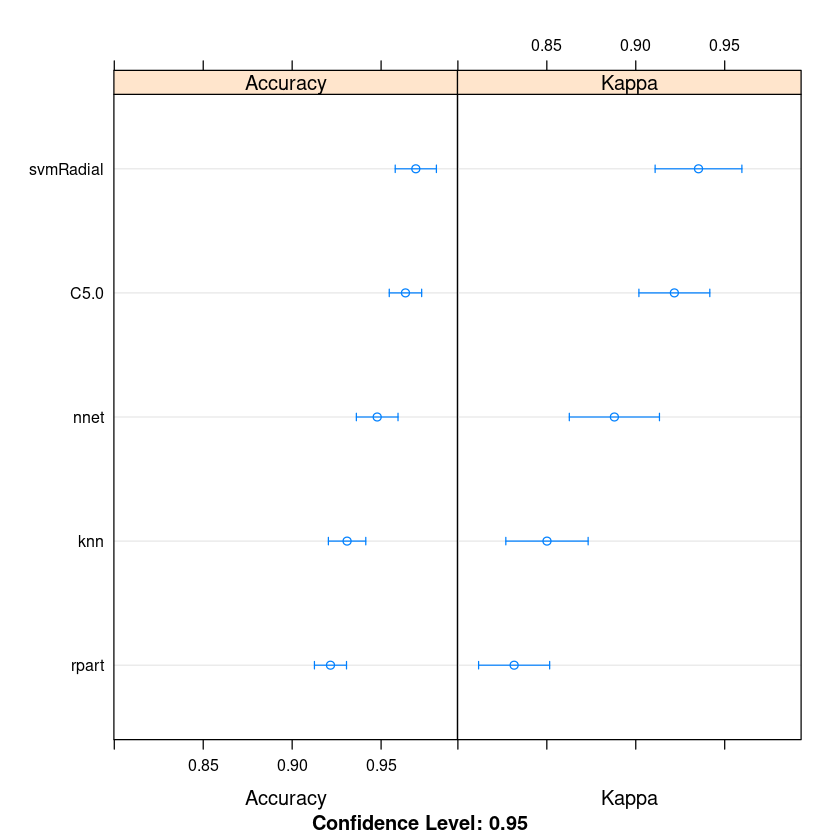

In [7]:
dotplot(results.N0)

In [8]:
modelCor(results.N0)

,nnet,rpart,C5.0,knn,svmRadial
nnet,1.0000000,0.1163560,0.2015316,0.7329345,0.3463562
rpart,0.1163560,1.0000000,0.4884161,0.2687946,0.2721461
C5.0,0.2015316,0.4884161,1.0000000,0.2200800,0.5881069
knn,0.7329345,0.2687946,0.2200800,1.0000000,0.2184746
svmRadial,0.3463562,0.2721461,0.5881069,0.2184746,1.0000000


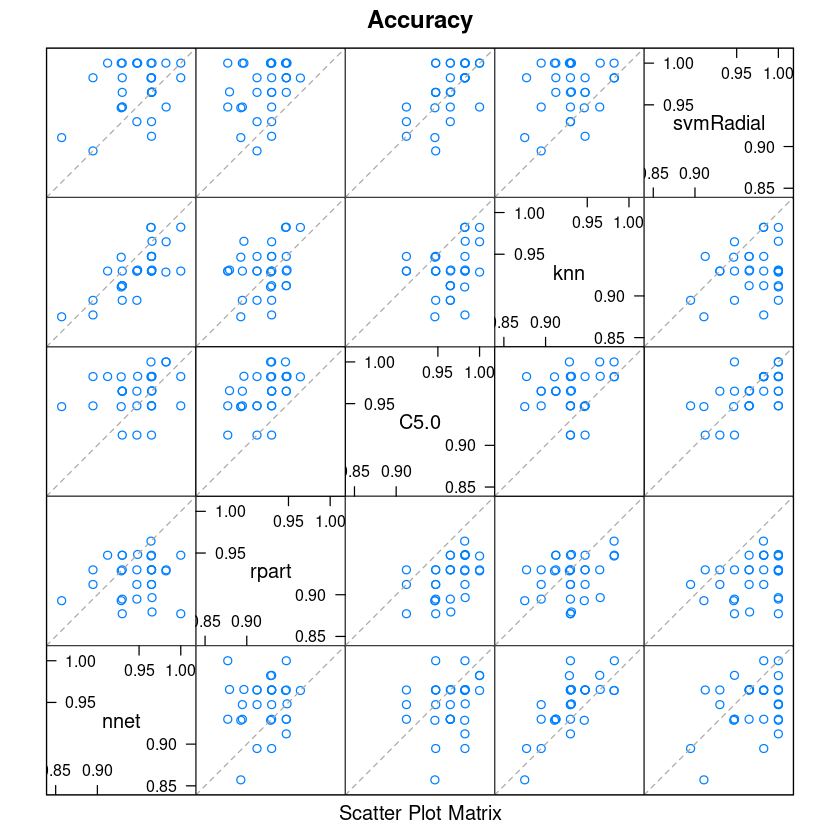

In [9]:
splom(results.N0)

## 4. Construcción del modelo final

### Parámetros de construcción

In [10]:
stackControl <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)

### Creación del modelo

In [11]:
N1.rf <- caretStack(models, method="rf", metric="Accuracy", trControl=stackControl)

###  Mostramos las características del modelo

In [12]:
print(N1.rf)

A rf ensemble of 5 base models: nnet, rpart, C5.0, knn, svmRadial

Ensemble results:
Random Forest 

1707 samples
   5 predictor
   2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1536, 1536, 1537, 1537, 1536, 1537, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9798955  0.9568792
  3     0.9795034  0.9560515
  5     0.9791135  0.9552296

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.
